 ## Remarque : 
        - L'execution ( les résultats ) affichés ne convient pas avec les données parceque on a changé le nombres de fichiers Json utilisés avant qu'on vous transmet le projet . 
        - il faut reéxecuter le code avec le nombre de fichiers souhaités pour avoir des bons résultat
        - les parties ambigué et la ou on a trouvé des problems on les a marqué par des commentaires 
        
#//////////////////////////////////////////////////////////////

#//////////////////////////////////////////////////////////////

#//////////////////////////////////////////////////////////////

#les remarque sont écrit de cette forme

#//////////////////////////////////////////////////////////////

#//////////////////////////////////////////////////////////////

#//////////////////////////////////////////////////////////////


# COVID-19 Literature Clustering

# Table of Contents
1. Loading the data
2. Pre-processing
3. Vectorization
4. PCA  & Clustering
5. Dimensionality Reduction with t-SNE
6. Topic Modeling on Each Cluster
7. Classify
8. Plot
9. How to Use the Plot?
10. Conclusion
11. Citation/Sources

<br>

# Loading the Data


https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge

### Loading Metadata

In [36]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json

import matplotlib.pyplot as plt
plt.style.use('ggplot')

Let's load the metadata of the dateset. 'title' and 'journal' attributes may be useful later when we cluster the articles to see what kinds of articles cluster together.

In [37]:
root_path = 'C:/Users/Seyf_GOUMEIDA/Documents/GitHub/archive'
#root_path = 'C:/Users/moham/Downloads/archive'

metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

C:\Users\Seyf_GOUMEIDA\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1,5,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [38]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522159 entries, 0 to 522158
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          522159 non-null  object 
 1   sha               176592 non-null  object 
 2   source_x          522159 non-null  object 
 3   title             521918 non-null  object 
 4   doi               287709 non-null  object 
 5   pmcid             186262 non-null  object 
 6   pubmed_id         248397 non-null  object 
 7   license           522159 non-null  object 
 8   abstract          379944 non-null  object 
 9   publish_time      521940 non-null  object 
 10  authors           507699 non-null  object 
 11  journal           487988 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  215684 non-null  object 
 14  arxiv_id          6806 non-null    object 
 15  pdf_json_files    176592 non-null  object 
 16  pmc_json_files    14

### Fetch All of JSON File Path

Get path to all JSON files:

In [39]:
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
len(all_json)

330230

### Helper Functions

 #### File Reader Class

In [40]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

0000028b5cc154f68b8a269f6578f21e31f62977: ... According to current live statistics at the time of editing this letter, Russia has been the third country in the world to be affected by COVID-19 with both new cases and death rates rising. It remain...


Helper function adds break after every words when character length reach to certain amount. This is for the interactive plot so that hover tool fits the screen.

In [41]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

### Load the Data into DataFrame

Using the helper functions, let's read in the articles into a DataFrame that can be used easily:

In [159]:
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#ici on met le nombre des fichiers Json a selectionnés 
#avec 1000 ça prend un temps énorme pour s'executer
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
    if idx > 5000:
        break
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 100 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # if more than 2 authors, take them all with html tag breaks in between
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 330230


,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary
0,0000028b5cc154f68b8a269f6578f21e31f62977,10.1002/bjs.11940,,According to current live statistics at the ti...,"Tsarkov, Petr V.. Zubayraeva, Albina A.. <br...",“Multi‐faceted” COVID‐19: Russian<br>experience,Br J Surg,Not provided.
1,00006903b396d50cc0037fed39916d57d50ee801,NaN,Urban green space has been regarded as contrib...,The advantages of urban green space for public...,"Kwon, Oh-Hyun. Hong, Inho. Yang, Jeasurk. <...",Urban green space and happiness in developed<...,NaN,Urban green space has been regarded as<br>con...
2,0000b93c66f991236db92dc16fa6db119b27ca12,10.1007/978-3-030-36358-1_7,,Infections are an important cause of morbidity...,"George, Biju. Bhattacharya, Sanjay",Infections in Hematopoietic Stem Cell<br>Tran...,Contemporary Bone Marrow Transplantation,Not provided.
3,0000fcce604204b1b9d876dc073eb529eb5ce305,10.1016/j.regg.2021.01.002,Contribución de los autores: Rocío Menéndez Co...,Se calcula que en España existen cerca de 367....,"Menéndez-Colino, Rocío. Argentina,<br>France...",La Geriatría de Enlace con residencias en la<...,Rev Esp Geriatr Gerontol,Contribución de los autores: Rocío Menéndez<b...
4,000122a9a774ec76fa35ec0c0f6734e7e8d0c541,10.1016/j.rec.2020.08.002,Introduction and objectives: The COVID-19 outb...,Introduction and objectives: The COVID-19 outb...,"Rodríguez-Leor, Oriol. Cid-Álvarez, Belén. <...",Impact of COVID-19 on ST-segment elevation<br...,Rev Esp Cardiol (Engl Ed),Introduction and objectives: The COVID-19<br>...


## Some feature engineering
Adding word count columns for both abstract and body_text can be useful parameters later:

In [160]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,0000028b5cc154f68b8a269f6578f21e31f62977,10.1002/bjs.11940,,According to current live statistics at the ti...,"Tsarkov, Petr V.. Zubayraeva, Albina A.. <br...",“Multi‐faceted” COVID‐19: Russian<br>experience,Br J Surg,Not provided.,0,635,349
1,00006903b396d50cc0037fed39916d57d50ee801,NaN,Urban green space has been regarded as contrib...,The advantages of urban green space for public...,"Kwon, Oh-Hyun. Hong, Inho. Yang, Jeasurk. <...",Urban green space and happiness in developed<...,NaN,Urban green space has been regarded as<br>con...,191,5040,1522
2,0000b93c66f991236db92dc16fa6db119b27ca12,10.1007/978-3-030-36358-1_7,,Infections are an important cause of morbidity...,"George, Biju. Bhattacharya, Sanjay",Infections in Hematopoietic Stem Cell<br>Tran...,Contemporary Bone Marrow Transplantation,Not provided.,0,6824,2232
3,0000fcce604204b1b9d876dc073eb529eb5ce305,10.1016/j.regg.2021.01.002,Contribución de los autores: Rocío Menéndez Co...,Se calcula que en España existen cerca de 367....,"Menéndez-Colino, Rocío. Argentina,<br>France...",La Geriatría de Enlace con residencias en la<...,Rev Esp Geriatr Gerontol,Contribución de los autores: Rocío Menéndez<b...,406,5021,1659
4,000122a9a774ec76fa35ec0c0f6734e7e8d0c541,10.1016/j.rec.2020.08.002,Introduction and objectives: The COVID-19 outb...,Introduction and objectives: The COVID-19 outb...,"Rodríguez-Leor, Oriol. Cid-Álvarez, Belén. <...",Impact of COVID-19 on ST-segment elevation<br...,Rev Esp Cardiol (Engl Ed),Introduction and objectives: The COVID-19<br>...,286,3508,1297


In [161]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             92 non-null     object
 1   doi                  89 non-null     object
 2   abstract             92 non-null     object
 3   body_text            92 non-null     object
 4   authors              91 non-null     object
 5   title                92 non-null     object
 6   journal              86 non-null     object
 7   abstract_summary     92 non-null     object
 8   abstract_word_count  92 non-null     int64 
 9   body_word_count      92 non-null     int64 
 10  body_unique_words    92 non-null     int64 
dtypes: int64(3), object(8)
memory usage: 8.0+ KB


In [162]:
df_covid['abstract'].describe(include='all')

count     92
unique    57
top         
freq      36
Name: abstract, dtype: object

## Handle Possible Duplicates

When we look at the unique values above, we can see that tehre are duplicates. It may have caused because of author submiting the article to multiple journals. Let's remove the duplicats from our dataset:

(Thank you Desmond Yeoh for recommending the below approach on Kaggle)

In [163]:
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)
df_covid['abstract'].describe(include='all')

count     92
unique    57
top         
freq      36
Name: abstract, dtype: object

In [164]:
df_covid['body_text'].describe(include='all')

count                                                    92
unique                                                   92
top       Severe acute respiratory syndrome coronavirus ...
freq                                                      1
Name: body_text, dtype: object

It looks like we didn't have duplicates. Instead, it was articles without Abstracts.

## Take a Look at the Data:

In [165]:
df_covid.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words
0,0000028b5cc154f68b8a269f6578f21e31f62977,10.1002/bjs.11940,,According to current live statistics at the ti...,"Tsarkov, Petr V.. Zubayraeva, Albina A.. <br...",“Multi‐faceted” COVID‐19: Russian<br>experience,Br J Surg,Not provided.,0,635,349
1,00006903b396d50cc0037fed39916d57d50ee801,NaN,Urban green space has been regarded as contrib...,The advantages of urban green space for public...,"Kwon, Oh-Hyun. Hong, Inho. Yang, Jeasurk. <...",Urban green space and happiness in developed<...,NaN,Urban green space has been regarded as<br>con...,191,5040,1522
2,0000b93c66f991236db92dc16fa6db119b27ca12,10.1007/978-3-030-36358-1_7,,Infections are an important cause of morbidity...,"George, Biju. Bhattacharya, Sanjay",Infections in Hematopoietic Stem Cell<br>Tran...,Contemporary Bone Marrow Transplantation,Not provided.,0,6824,2232
3,0000fcce604204b1b9d876dc073eb529eb5ce305,10.1016/j.regg.2021.01.002,Contribución de los autores: Rocío Menéndez Co...,Se calcula que en España existen cerca de 367....,"Menéndez-Colino, Rocío. Argentina,<br>France...",La Geriatría de Enlace con residencias en la<...,Rev Esp Geriatr Gerontol,Contribución de los autores: Rocío Menéndez<b...,406,5021,1659
4,000122a9a774ec76fa35ec0c0f6734e7e8d0c541,10.1016/j.rec.2020.08.002,Introduction and objectives: The COVID-19 outb...,Introduction and objectives: The COVID-19 outb...,"Rodríguez-Leor, Oriol. Cid-Álvarez, Belén. <...",Impact of COVID-19 on ST-segment elevation<br...,Rev Esp Cardiol (Engl Ed),Introduction and objectives: The COVID-19<br>...,286,3508,1297


In the majority of this notebook we will be working with **body_text** <br>
Links to the papers will be generated using **doi** 

In [166]:
df_covid.describe()

,abstract_word_count,body_word_count,body_unique_words
count,92.000000,92.000000,92.000000
mean,124.076087,3301.880435,1121.793478
std,133.024515,2248.907226,579.345264
min,0.000000,522.000000,279.000000
25%,0.000000,1640.750000,688.500000
50%,103.500000,2710.500000,921.000000
75%,213.000000,4482.250000,1522.000000
max,615.000000,9722.000000,2679.000000


# Data Pre-processing

### Réduction de la taille du dataset :

Unfortunately, running the next steps of the notebook is not possible on the full dataset within Kaggle. The full plot is available is at https://maksimekin.github.io/COVID19-Literature-Clustering/plots/t-sne_covid-19_interactive.html.

In Kaggle we will limit the dataframe to **10,000** instances

In [167]:
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#ici on choisit 80 fichiers entre les 100 qui sont déja lus 
# si on change le 100 en haut en doit changer aussi le nmbr des samples ici 
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////

#df = df_covid.sample(4000, random_state=42)
#del df_covid
df = df_covid

### Suppression des valeurs null :

Now that we have our dataset loaded, we need to clean-up the text to improve any clustering or classification efforts. First, let's drop Null vales:

In [168]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 0 to 91
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             85 non-null     object
 1   doi                  85 non-null     object
 2   abstract             85 non-null     object
 3   body_text            85 non-null     object
 4   authors              85 non-null     object
 5   title                85 non-null     object
 6   journal              85 non-null     object
 7   abstract_summary     85 non-null     object
 8   abstract_word_count  85 non-null     int64 
 9   body_word_count      85 non-null     int64 
 10  body_unique_words    85 non-null     int64 
dtypes: int64(3), object(8)
memory usage: 8.0+ KB


### Handling multiple languages
Next we are going to determine the language of each paper in the dataframe. Not all of the sources are English and the language needs to be identified so that we know how handle these instances

In [169]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████| 85/85 [00:01<00:00, 71.15it/s]


In [170]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 85

{'de': 2, 'en': 80, 'es': 2, 'fr': 1}


Lets take a look at the language distribution in the dataset

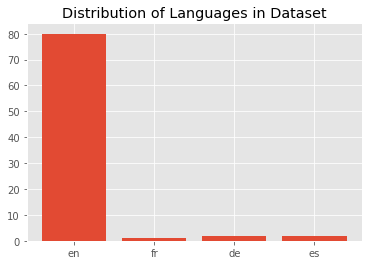

In [171]:
df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()


We will be dropping any language that is not English. Attempting to translate foreign texts gave the following problems:

1. API calls were limited

2. Translating the language may not carry over the true semantic meaning of the text


In [172]:
df = df[df['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 0 to 91
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   paper_id             80 non-null     object
 1   doi                  80 non-null     object
 2   abstract             80 non-null     object
 3   body_text            80 non-null     object
 4   authors              80 non-null     object
 5   title                80 non-null     object
 6   journal              80 non-null     object
 7   abstract_summary     80 non-null     object
 8   abstract_word_count  80 non-null     int64 
 9   body_word_count      80 non-null     int64 
 10  body_unique_words    80 non-null     int64 
 11  language             80 non-null     object
dtypes: int64(3), object(9)
memory usage: 8.1+ KB


In [173]:
#Download the spacy bio parser

from IPython.utils import io
with io.capture_output() as captured:
   !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz

In [174]:
import spacy.cli
spacy.cli.download("en_core_web_lg")
import en_core_web_lg
nlp = en_core_web_lg.load()

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [175]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step

### Stopwords

Part of the preprocessing will be finding and removing stopwords (common words that will act as noise in the clustering step).

In [176]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords

['neither',
 'be',
 'get',
 'mostly',
 'for',
 'see',
 'hereafter',
 'below',
 'alone',
 'without',
 'along',
 'it',
 'ourselves',
 'rather',
 'both',
 'whoever',
 'off',
 'us',
 'toward',
 'enough',
 'from',
 'or',
 'were',
 'those',
 'although',
 'used',
 'cannot',
 'most',
 'five',
 'one',
 'she',
 'them',
 'seeming',
 'too',
 'beside',
 'noone',
 'whereas',
 'former',
 'anything',
 'we',
 "n't",
 'elsewhere',
 'n‘t',
 'someone',
 'please',
 'herself',
 'down',
 'well',
 'had',
 'on',
 'did',
 'hers',
 'give',
 'there',
 'also',
 'what',
 'back',
 'via',
 'because',
 'was',
 'above',
 'about',
 'therein',
 'these',
 'since',
 'whom',
 'forty',
 'say',
 'front',
 'may',
 'somewhere',
 'must',
 'twenty',
 'again',
 'further',
 'around',
 'formerly',
 'others',
 'out',
 'any',
 'together',
 'per',
 'ever',
 'seems',
 'top',
 're',
 'keep',
 'once',
 'every',
 'nothing',
 'therefore',
 'hence',
 'you',
 'last',
 'next',
 'him',
 'somehow',
 'behind',
 'and',
 'during',
 'an',
 'is',
 'o

Now the above stopwords are used in everyday english text. Research papers will often frequently use words that don't actually contribute to the meaning and are not considered everyday stopwords.

Thank you Daniel Wolffram for the idea.
#### Cite: [Custom Stop Words | Topic Modeling: Finding Related Articles](https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles)

In [177]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

### Next lets create a function that will process the text data for us. 
For this purpose we will be using the spacy library. This function will convert text to lower case, remove punctuation, and find and remove stopwords. For the parser, we will use en_core_sci_lg. This is a model for processing biomedical, scientific or clinical text.

In [178]:
# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    #mytokens = [ word.lemma.lower().strip() if word.pos_ != "-PRON-" else word.lower for word.text in mytokens ]
    #mytokens2 = [word.lemma_.lower().strip() for word in mytokens if word.pos_ != "PUNCT" and word.text not in stopwords]

    mytokens = [ word for word in mytokens if word not in stopwords and word.text not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [179]:
cat = 5
type(cat)

int

Applying the text-processing function on the **body_text**. 

In [180]:
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#c'est dans cette partie la que ça bug , ça prend un temps énorme et on a pas eu de résultat  
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////
#tqdm.pandas()
#df["processed_text"] = df["body_text"].progress_apply(spacy_tokenizer)

In [181]:
import spacy
nlp = en_core_web_lg.load()
def spacy_process(texte):
    tmp = []
    tmp.append(texte)
    for lt in tmp:
        mytokens = nlp(lt)
        mytokens2 = [word.lemma_.lower().strip() for word in mytokens if word.pos_ != "PUNCT" and word.text not in stopwords]
        mytokens2 = " ".join([i for i in mytokens2])
    return mytokens2
df["processed_text"] = df["body_text"].progress_apply(spacy_process)
#a = ['je suis la bonne personne et droit à la caricature.', 'Je suis la bonne personne et droit à la caricature.']
#return :  je suis la bonne personne et droit à la caricature


100%|██████████| 80/80 [02:03<00:00,  1.54s/it]
<ipython-input-181-25c7055b245c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["processed_text"] = df["body_text"].progress_apply(spacy_process)


In [183]:
df.head()


,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language,processed_text
0,0000028b5cc154f68b8a269f6578f21e31f62977,10.1002/bjs.11940,,According to current live statistics at the ti...,"Tsarkov, Petr V.. Zubayraeva, Albina A.. <br...",“Multi‐faceted” COVID‐19: Russian<br>experience,Br J Surg,Not provided.,0,635,349,en,accord current live statistic time edit letter...
2,0000b93c66f991236db92dc16fa6db119b27ca12,10.1007/978-3-030-36358-1_7,,Infections are an important cause of morbidity...,"George, Biju. Bhattacharya, Sanjay",Infections in Hematopoietic Stem Cell<br>Tran...,Contemporary Bone Marrow Transplantation,Not provided.,0,6824,2232,en,infection important cause morbidity mortality ...
4,000122a9a774ec76fa35ec0c0f6734e7e8d0c541,10.1016/j.rec.2020.08.002,Introduction and objectives: The COVID-19 outb...,Introduction and objectives: The COVID-19 outb...,"Rodríguez-Leor, Oriol. Cid-Álvarez, Belén. <...",Impact of COVID-19 on ST-segment elevation<br...,Rev Esp Cardiol (Engl Ed),Introduction and objectives: The COVID-19<br>...,286,3508,1297,en,introduction objective the covid-19 outbreak u...
5,0001418189999fea7f7cbe3e82703d71c85a6fe5,10.1016/j.vetmic.2006.11.026,Feline infectious peritonitis virus (FIPV) pos...,Feline infectious peritonitis (FIP) is a fatal...,"Cornelissen, E.. Dewerchin, H. L.. Van Hamm...",Absence of surface expression of feline<br>in...,Veterinary Microbiology,Feline infectious peritonitis virus (FIPV)<br...,165,2071,756,en,feline infectious peritonitis fip fatal chroni...
6,000159d40045de3f55c9ddd5d99d760d679d4910,10.1007/978-3-030-64769-8_13,"The CCTV surveillance center (below to ""Center...",The 4th Industrial Revolution technology is be...,"Lim, Donghyun. Park, Deawoo",AI Analysis of Illegal Parking Data at Seocho...,Data Science and Digital Transformation in the...,"The CCTV surveillance center (below to<br>""Ce...",148,1981,696,en,the 4th industrial revolution technology apply...


### Removal of Frequent words
So this step is to remove the frequent words in the given corpus. If we use something like tfidf, this is automatically taken care of.

In [236]:
from collections import Counter
cnt = Counter()
for text in df["processed_text"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(40)

[('the', 1854),
 ('-', 1252),
 ('patient', 1194),
 ('cell', 935),
 ('%', 925),
 ('study', 863),
 ('infection', 826),
 ('covid-19', 780),
 ('in', 729),
 ('/', 724),
 ('1', 661),
 ('virus', 652),
 ('2', 629),
 ('high', 611),
 ('sars', 550),
 ('protein', 537),
 ('risk', 532),
 ('time', 522),
 ('include', 517),
 ('result', 502),
 ('case', 462),
 ('test', 459),
 ('show', 457),
 ('3', 452),
 ('increase', 452),
 ('this', 443),
 ('disease', 434),
 ('group', 421),
 ('cov-2', 417),
 ('sample', 416),
 ('viral', 402),
 ('water', 399),
 ('l', 399),
 ('level', 387),
 ('report', 378),
 ('10', 377),
 ('system', 370),
 ('day', 364),
 ('4', 363),
 ('analysis', 362)]

In [237]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(30)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df["text_wo_stopfreq"] = df["processed_text"].apply(lambda text: remove_freqwords(text))


<ipython-input-237-e97c1f8b22c9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_wo_stopfreq"] = df["processed_text"].apply(lambda text: remove_freqwords(text))


In [238]:
df["body_text"]

0     According to current live statistics at the ti...
2     Infections are an important cause of morbidity...
4     Introduction and objectives: The COVID-19 outb...
5     Feline infectious peritonitis (FIP) is a fatal...
6     The 4th Industrial Revolution technology is be...
                            ...                        
87    The first confirmed case of coronavirus 2019 i...
88    SARS-CoV-2, the causal agent of COVID-19, firs...
89    There has been a dramatic increase in the case...
90    eat and move about freely, making the poor in ...
91    Respiratory Distress Syndrome (RDS) affects 85...
Name: body_text, Length: 80, dtype: object

In [239]:
df["text_wo_stopfreq"]

0     accord current live statistic edit letter russ...
2     important cause morbidity mortality hospital s...
4     introduction objective outbreak unclear impact...
5     feline infectious peritonitis fip fatal chroni...
6     4th industrial revolution technology apply rea...
                            ...                        
87    confirm coronavirus 2019 mexico city report fe...
88    causal agent emerge late 2019 china it infect ...
89    there dramatic mortality relate coronavirus 20...
90    eat freely make poor northeastern nigeria susc...
91    respiratory distress syndrome rds affect 85 pr...
Name: text_wo_stopfreq, Length: 80, dtype: object

In [240]:
df["processed_text"]

0     accord current live statistic time edit letter...
2     infection important cause morbidity mortality ...
4     introduction objective the covid-19 outbreak u...
5     feline infectious peritonitis fip fatal chroni...
6     the 4th industrial revolution technology apply...
                            ...                        
87    the confirm case coronavirus 2019 mexico city ...
88    sars cov-2 causal agent covid-19 emerge late 2...
89    there dramatic increase case mortality relate ...
90    eat freely make poor northeastern nigeria susc...
91    respiratory distress syndrome rds affect 85 % ...
Name: processed_text, Length: 80, dtype: object

### Removal of Rare words
This is very similar to previous preprocessing step but we will remove the rare words from the corpus.

In [241]:
#cnt.most_common()[:-500-1:-1]

In [242]:
# n_rare_words = 10
# RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
# def remove_rarewords(text):
#     """custom function to remove the rare words"""
#     return " ".join([word for word in str(text).split() if word not in RAREWORDS])

# df["text_wo_stopfreqrare"] = df["text_wo_stopfreq"].apply(lambda text: remove_rarewords(text))
# df.head()

### Lemmatization

Lemmatization is similar to stemming in reducing inflected words to their word stem but differs in the way that it makes sure the root word (also called as lemma) belongs to the language.

In [243]:
import nltk
#nltk.download('wordnet')

In [244]:
#from nltk.stem import WordNetLemmatizer
#lemmatizer = WordNetLemmatizer()
#def lemmatize_words(text):
#    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])#
#df["text_lemmatized"] = df["text_wo_stopfreq"].apply(lambda text: lemmatize_words(text))
#df.head()

Now let us redo the lemmatization process for our dataset.

In [245]:
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Seyf_GOUMEIDA\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [246]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

df["text_lemmatized"] = df["text_wo_stopfreq"].apply(lambda text: lemmatize_words(text))


<ipython-input-246-a975cedaa34d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_lemmatized"] = df["text_wo_stopfreq"].apply(lambda text: lemmatize_words(text))


In [247]:
df.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language,processed_text,text_wo_stopfreq,text_lemmatized,text_lemmatized_no_url,text_lemmatized_url_html,y
0,0000028b5cc154f68b8a269f6578f21e31f62977,10.1002/bjs.11940,,According to current live statistics at the ti...,"Tsarkov, Petr V.. Zubayraeva, Albina A.. <br...",“Multi‐faceted” COVID‐19: Russian<br>experience,Br J Surg,Not provided.,0,635,349,en,accord current live statistic time edit letter...,accord current live statistic edit letter russ...,accord current live statistic edit letter russ...,According current live statistic time edit let...,According current live statistic time edit let...,1
2,0000b93c66f991236db92dc16fa6db119b27ca12,10.1007/978-3-030-36358-1_7,,Infections are an important cause of morbidity...,"George, Biju. Bhattacharya, Sanjay",Infections in Hematopoietic Stem Cell<br>Tran...,Contemporary Bone Marrow Transplantation,Not provided.,0,6824,2232,en,infection important cause morbidity mortality ...,important cause morbidity mortality hospital s...,important cause morbidity mortality hospital s...,"Infections important cause morbidity, mortalit...","Infections important cause morbidity, mortalit...",4
4,000122a9a774ec76fa35ec0c0f6734e7e8d0c541,10.1016/j.rec.2020.08.002,Introduction and objectives: The COVID-19 outb...,Introduction and objectives: The COVID-19 outb...,"Rodríguez-Leor, Oriol. Cid-Álvarez, Belén. <...",Impact of COVID-19 on ST-segment elevation<br...,Rev Esp Cardiol (Engl Ed),Introduction and objectives: The COVID-19<br>...,286,3508,1297,en,introduction objective the covid-19 outbreak u...,introduction objective outbreak unclear impact...,introduction objective outbreak unclear impact...,Introduction objectives: COVID-19 outbreak hav...,Introduction objectives: COVID-19 outbreak hav...,1
5,0001418189999fea7f7cbe3e82703d71c85a6fe5,10.1016/j.vetmic.2006.11.026,Feline infectious peritonitis virus (FIPV) pos...,Feline infectious peritonitis (FIP) is a fatal...,"Cornelissen, E.. Dewerchin, H. L.. Van Hamm...",Absence of surface expression of feline<br>in...,Veterinary Microbiology,Feline infectious peritonitis virus (FIPV)<br...,165,2071,756,en,feline infectious peritonitis fip fatal chroni...,feline infectious peritonitis fip fatal chroni...,feline infectious peritonitis fip fatal chroni...,Feline infectious peritonitis (FIP) fatal chro...,Feline infectious peritonitis (FIP) fatal chro...,3
6,000159d40045de3f55c9ddd5d99d760d679d4910,10.1007/978-3-030-64769-8_13,"The CCTV surveillance center (below to ""Center...",The 4th Industrial Revolution technology is be...,"Lim, Donghyun. Park, Deawoo",AI Analysis of Illegal Parking Data at Seocho...,Data Science and Digital Transformation in the...,"The CCTV surveillance center (below to<br>""Ce...",148,1981,696,en,the 4th industrial revolution technology apply...,4th industrial revolution technology apply rea...,4th industrial revolution technology apply rea...,4th Industrial Revolution technology be apply ...,4th Industrial Revolution technology be apply ...,1


### Removal of URLs

In [248]:
import re
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [249]:
df["text_lemmatized_no_url"] = df["text_lemmatized"].apply(lambda text: remove_urls(text))
df.head()
    

<ipython-input-249-a38abe2b0ba1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_lemmatized_no_url"] = df["text_lemmatized"].apply(lambda text: remove_urls(text))


,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language,processed_text,text_wo_stopfreq,text_lemmatized,text_lemmatized_no_url,text_lemmatized_url_html,y
0,0000028b5cc154f68b8a269f6578f21e31f62977,10.1002/bjs.11940,,According to current live statistics at the ti...,"Tsarkov, Petr V.. Zubayraeva, Albina A.. <br...",“Multi‐faceted” COVID‐19: Russian<br>experience,Br J Surg,Not provided.,0,635,349,en,accord current live statistic time edit letter...,accord current live statistic edit letter russ...,accord current live statistic edit letter russ...,accord current live statistic edit letter russ...,According current live statistic time edit let...,1
2,0000b93c66f991236db92dc16fa6db119b27ca12,10.1007/978-3-030-36358-1_7,,Infections are an important cause of morbidity...,"George, Biju. Bhattacharya, Sanjay",Infections in Hematopoietic Stem Cell<br>Tran...,Contemporary Bone Marrow Transplantation,Not provided.,0,6824,2232,en,infection important cause morbidity mortality ...,important cause morbidity mortality hospital s...,important cause morbidity mortality hospital s...,important cause morbidity mortality hospital s...,"Infections important cause morbidity, mortalit...",4
4,000122a9a774ec76fa35ec0c0f6734e7e8d0c541,10.1016/j.rec.2020.08.002,Introduction and objectives: The COVID-19 outb...,Introduction and objectives: The COVID-19 outb...,"Rodríguez-Leor, Oriol. Cid-Álvarez, Belén. <...",Impact of COVID-19 on ST-segment elevation<br...,Rev Esp Cardiol (Engl Ed),Introduction and objectives: The COVID-19<br>...,286,3508,1297,en,introduction objective the covid-19 outbreak u...,introduction objective outbreak unclear impact...,introduction objective outbreak unclear impact...,introduction objective outbreak unclear impact...,Introduction objectives: COVID-19 outbreak hav...,1
5,0001418189999fea7f7cbe3e82703d71c85a6fe5,10.1016/j.vetmic.2006.11.026,Feline infectious peritonitis virus (FIPV) pos...,Feline infectious peritonitis (FIP) is a fatal...,"Cornelissen, E.. Dewerchin, H. L.. Van Hamm...",Absence of surface expression of feline<br>in...,Veterinary Microbiology,Feline infectious peritonitis virus (FIPV)<br...,165,2071,756,en,feline infectious peritonitis fip fatal chroni...,feline infectious peritonitis fip fatal chroni...,feline infectious peritonitis fip fatal chroni...,feline infectious peritonitis fip fatal chroni...,Feline infectious peritonitis (FIP) fatal chro...,3
6,000159d40045de3f55c9ddd5d99d760d679d4910,10.1007/978-3-030-64769-8_13,"The CCTV surveillance center (below to ""Center...",The 4th Industrial Revolution technology is be...,"Lim, Donghyun. Park, Deawoo",AI Analysis of Illegal Parking Data at Seocho...,Data Science and Digital Transformation in the...,"The CCTV surveillance center (below to<br>""Ce...",148,1981,696,en,the 4th industrial revolution technology apply...,4th industrial revolution technology apply rea...,4th industrial revolution technology apply rea...,4th industrial revolution technology apply rea...,4th Industrial Revolution technology be apply ...,1


### Removal of HTML Tags

In [250]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

In [251]:
df["text_lemmatized_url_html"] = df["text_lemmatized_no_url"].apply(lambda text: remove_html(text))
df.head()

<ipython-input-251-e19f1b691939>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_lemmatized_url_html"] = df["text_lemmatized_no_url"].apply(lambda text: remove_html(text))


,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,language,processed_text,text_wo_stopfreq,text_lemmatized,text_lemmatized_no_url,text_lemmatized_url_html,y
0,0000028b5cc154f68b8a269f6578f21e31f62977,10.1002/bjs.11940,,According to current live statistics at the ti...,"Tsarkov, Petr V.. Zubayraeva, Albina A.. <br...",“Multi‐faceted” COVID‐19: Russian<br>experience,Br J Surg,Not provided.,0,635,349,en,accord current live statistic time edit letter...,accord current live statistic edit letter russ...,accord current live statistic edit letter russ...,accord current live statistic edit letter russ...,accord current live statistic edit letter russ...,1
2,0000b93c66f991236db92dc16fa6db119b27ca12,10.1007/978-3-030-36358-1_7,,Infections are an important cause of morbidity...,"George, Biju. Bhattacharya, Sanjay",Infections in Hematopoietic Stem Cell<br>Tran...,Contemporary Bone Marrow Transplantation,Not provided.,0,6824,2232,en,infection important cause morbidity mortality ...,important cause morbidity mortality hospital s...,important cause morbidity mortality hospital s...,important cause morbidity mortality hospital s...,important cause morbidity mortality hospital s...,4
4,000122a9a774ec76fa35ec0c0f6734e7e8d0c541,10.1016/j.rec.2020.08.002,Introduction and objectives: The COVID-19 outb...,Introduction and objectives: The COVID-19 outb...,"Rodríguez-Leor, Oriol. Cid-Álvarez, Belén. <...",Impact of COVID-19 on ST-segment elevation<br...,Rev Esp Cardiol (Engl Ed),Introduction and objectives: The COVID-19<br>...,286,3508,1297,en,introduction objective the covid-19 outbreak u...,introduction objective outbreak unclear impact...,introduction objective outbreak unclear impact...,introduction objective outbreak unclear impact...,introduction objective outbreak unclear impact...,1
5,0001418189999fea7f7cbe3e82703d71c85a6fe5,10.1016/j.vetmic.2006.11.026,Feline infectious peritonitis virus (FIPV) pos...,Feline infectious peritonitis (FIP) is a fatal...,"Cornelissen, E.. Dewerchin, H. L.. Van Hamm...",Absence of surface expression of feline<br>in...,Veterinary Microbiology,Feline infectious peritonitis virus (FIPV)<br...,165,2071,756,en,feline infectious peritonitis fip fatal chroni...,feline infectious peritonitis fip fatal chroni...,feline infectious peritonitis fip fatal chroni...,feline infectious peritonitis fip fatal chroni...,feline infectious peritonitis fip fatal chroni...,3
6,000159d40045de3f55c9ddd5d99d760d679d4910,10.1007/978-3-030-64769-8_13,"The CCTV surveillance center (below to ""Center...",The 4th Industrial Revolution technology is be...,"Lim, Donghyun. Park, Deawoo",AI Analysis of Illegal Parking Data at Seocho...,Data Science and Digital Transformation in the...,"The CCTV surveillance center (below to<br>""Ce...",148,1981,696,en,the 4th industrial revolution technology apply...,4th industrial revolution technology apply rea...,4th industrial revolution technology apply rea...,4th industrial revolution technology apply rea...,4th industrial revolution technology apply rea...,1


### Let's take a look at word count in the papers

In [252]:
import seaborn as sns

C:\Users\Seyf_GOUMEIDA\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count      80.000000
mean     3370.375000
std      2311.341089
min       522.000000
25%      1640.750000
50%      2712.500000
75%      4482.250000
max      9722.000000
Name: body_word_count, dtype: float64

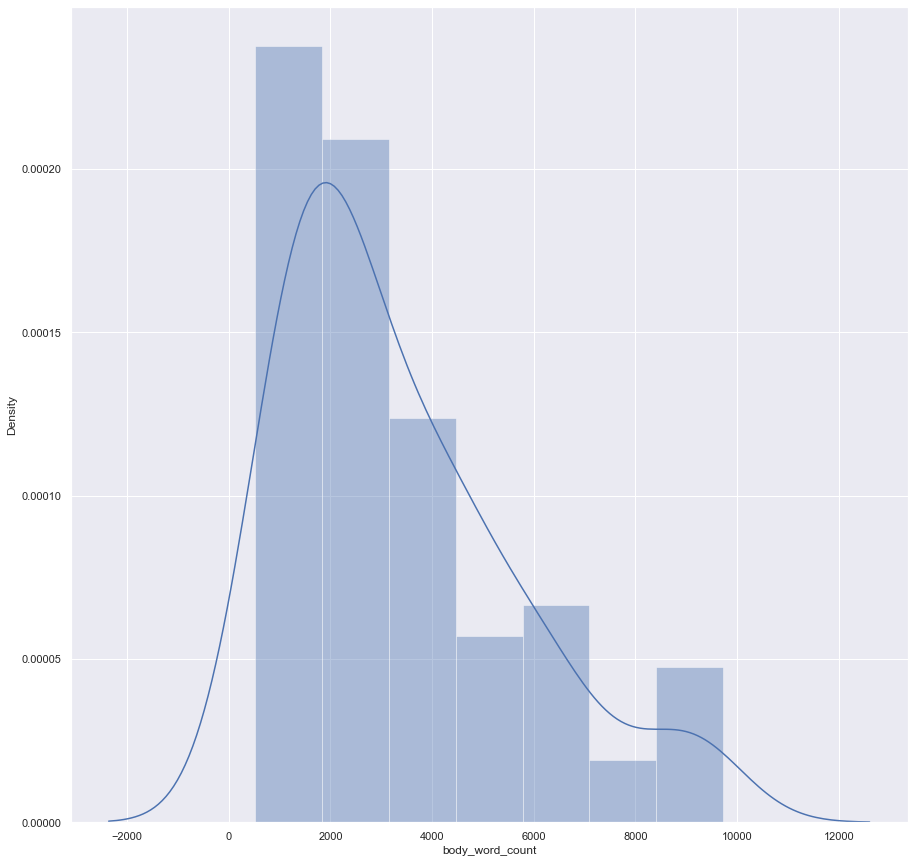

In [253]:
sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

C:\Users\Seyf_GOUMEIDA\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count      80.00000
mean     1133.62500
std       588.60772
min       279.00000
25%       688.50000
50%       932.00000
75%      1526.50000
max      2679.00000
Name: body_unique_words, dtype: float64

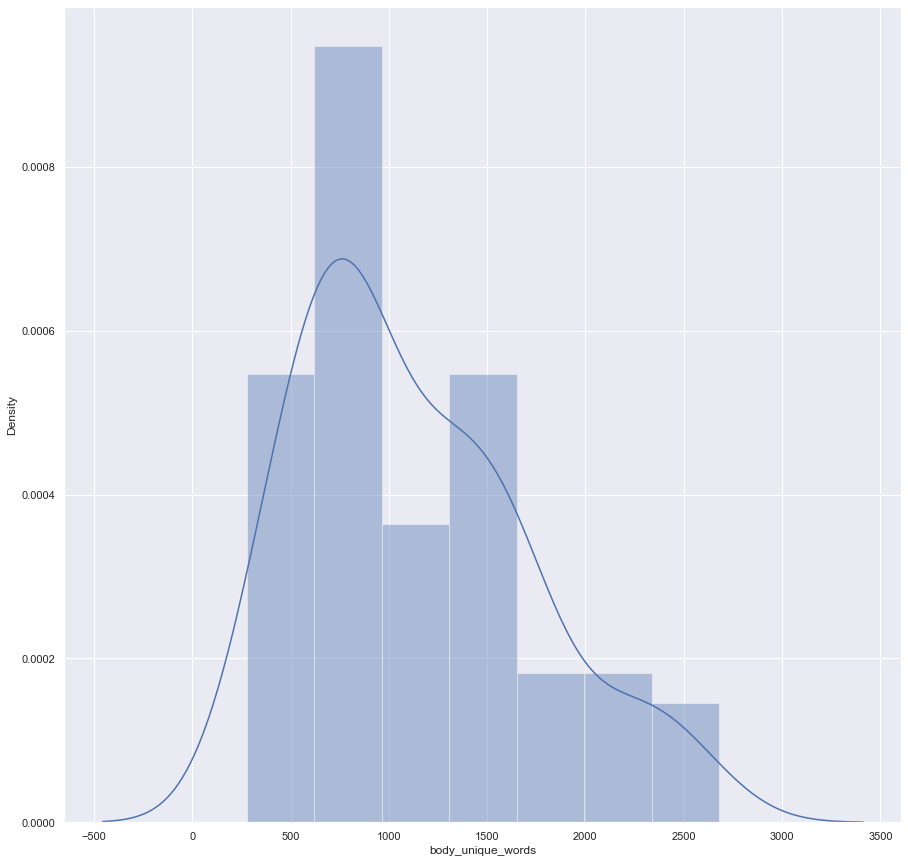

In [254]:
sns.distplot(df['body_unique_words'])
df['body_unique_words'].describe()

These two plots give us a good idea of the content we are dealing with. Most papers are about 5000 words in length. The long tails in both plots are caused by outliers. In fact, ~98% of the papers are under 20,000 words in length while a select few are over 200,000! <br><br>

# Vectorization

Now that we have pre-processed the data, it is time to convert it into a format that can be handled by our algorithms. For this purpose we will be using tf-idf. This will convert our string formatted data into a measure of how important each word is to the instance out of the literature as a whole.

In [255]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    global vectorizer 
    X = vectorizer.fit_transform(text)
    return X

Vectorize our data. We will be clustering based off the content of the body text. The maximum number of features will be limited. Only the top 2 ** 12 features will be used, eseentially acting as a noise filter. Additionally, more features cause painfully long runtimes.

In [256]:
text = df['text_lemmatized_url_html'].values
vectorizer = TfidfVectorizer(max_features= 2 ** 12)
X = vectorize(text, 2 ** 12)
X.shape
print(X)

  (0, 454)	0.042782685936239614
  (0, 1228)	0.046170879152560296
  (0, 3450)	0.036860909334789256
  (0, 3120)	0.050452055903525084
  (0, 893)	0.05409324151221717
  (0, 3221)	0.0488968146562587
  (0, 3740)	0.030970008206011694
  (0, 301)	0.03914150032754753
  (0, 2197)	0.056272164372723164
  (0, 1007)	0.022933933313431278
  (0, 190)	0.03997848801662202
  (0, 2679)	0.030482877033467196
  (0, 3534)	0.03486032357658274
  (0, 3718)	0.022634517895611498
  (0, 2421)	0.029550184187700723
  (0, 2074)	0.044961608796745614
  (0, 2716)	0.03834535792247616
  (0, 4059)	0.03997848801662202
  (0, 1824)	0.022933933313431278
  (0, 944)	0.03834535792247616
  (0, 985)	0.04383580502925564
  (0, 3095)	0.03616643506197017
  (0, 269)	0.04086073976367828
  (0, 1212)	0.02627570350430359
  (0, 1199)	0.05217129533965583
  :	:
  (79, 2785)	0.04844456242423084
  (79, 922)	0.04422475009672659
  (79, 3942)	0.05962561659797059
  (79, 2306)	0.017035890456563025
  (79, 2508)	0.025539053490543792
  (79, 2895)	0.025023767

# PCA  & Clustering

Let's see how much we can reduce the dimensions while still keeping 95% variance. We will apply Principle Component Analysis (PCA) to our vectorized data. The reason for this is that by keeping a large number of dimensions with PCA, you don’t destroy much of the information, but hopefully will remove some noise/outliers from the data, and make the clustering problem easier for k-means. Note that X_reduced will only be used for k-means, t-SNE will still use the original feature vector X that was generated through tf-idf on the NLP processed text.

(Thank you Dr. Edward Raff for the suggestion)

In [257]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(80, 73)

To separate the literature, k-means will be run on the vectorized text. Given the number of clusters, k, k-means will categorize each vector by taking the mean distance to a randomly initialized centroid. The centroids are updated iteratively.

In [258]:
from sklearn.cluster import KMeans

### How many clusters? 

To find the best k value for k-means we'll look at the distortion at different k values. Distortion computes the sum of squared distances from each point to its assigned center. When distortion is plotted against k there will be a k value after which decreases in distortion are minimal. This is the desired number of clusters.

In [259]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 10)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

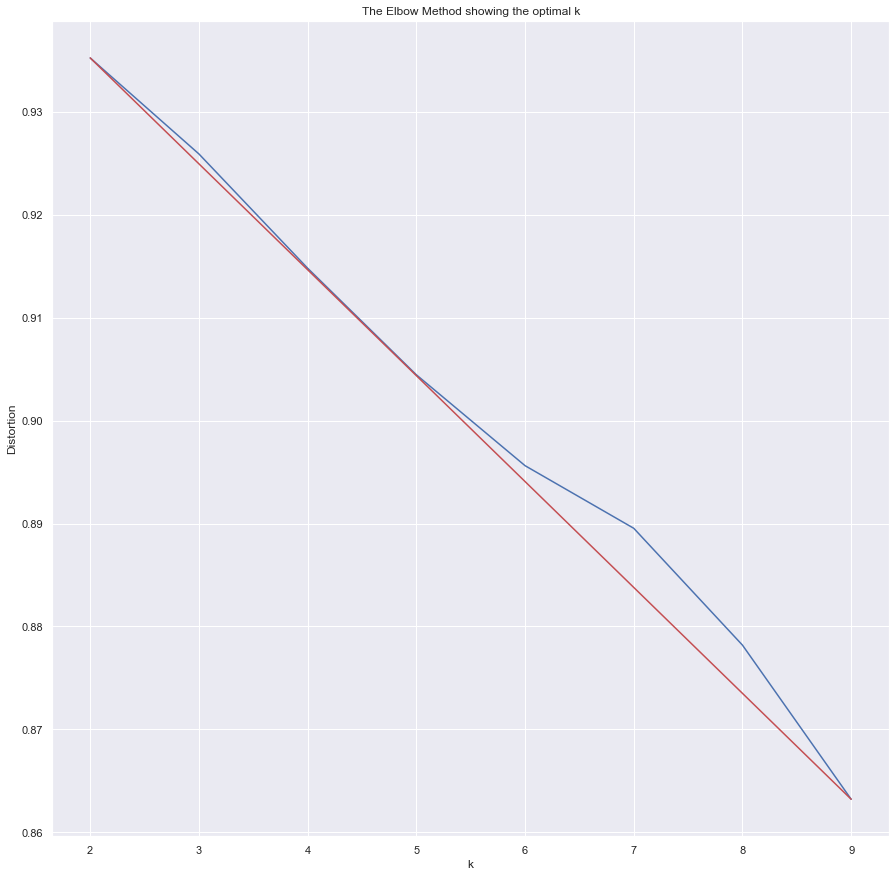

In [260]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In this plot we can see that the better k values are between 18-25. After that, the decrease in distortion is not as significant. For simplicity, we will use k=20

### Run k-means

Now that we have an appropriate k value, we can run k-means on the PCA-processed feature vector (X_reduced). 

In [261]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred
df['y']

<ipython-input-261-fe9c866d954f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = y_pred


0     1
2     1
4     1
5     4
6     1
     ..
87    3
88    4
89    1
90    3
91    1
Name: y, Length: 80, dtype: int32

# Dimensionality Reduction with t-SNE

In [262]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 79 nearest neighbors...
[t-SNE] Indexed 80 samples in 0.003s...
[t-SNE] Computed neighbors for 80 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 80 / 80
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.180550
[t-SNE] KL divergence after 1000 iterations: 0.001435


So that step took a while! Let's take a look at what our data looks like when compressed to 2 dimensions. 

C:\Users\Seyf_GOUMEIDA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


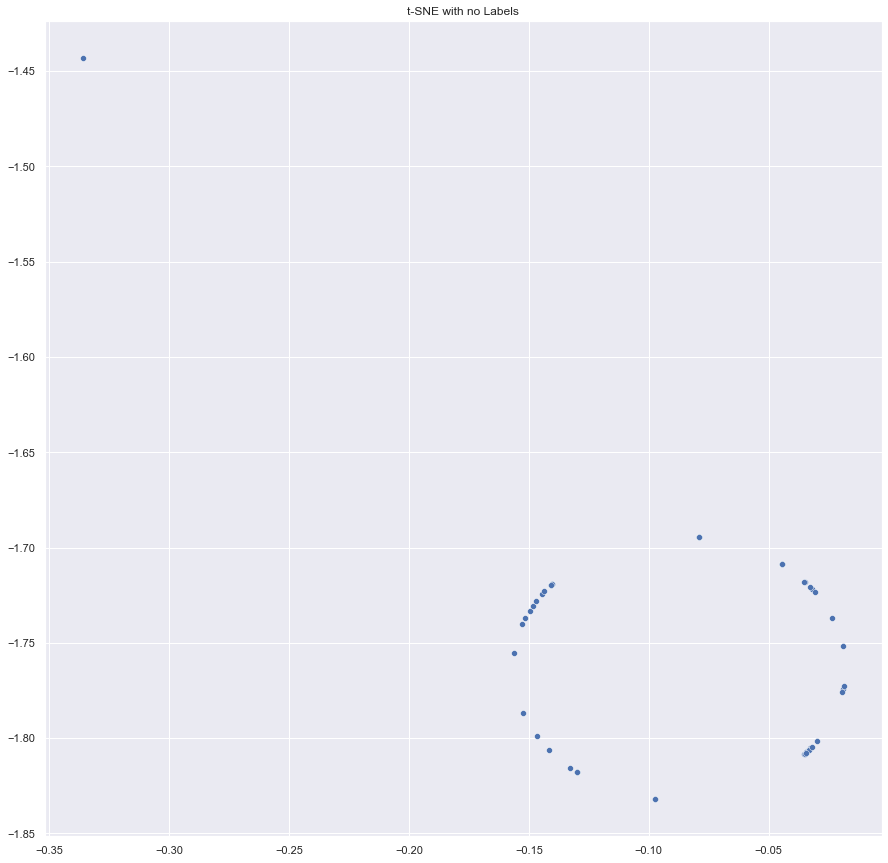

In [263]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

This looks pretty bland. There are some clusters we can immediately detect, but the many instances closer to the center are harder to separate. t-SNE did a good job at reducing the dimensionality, but now we need some labels. Let's use the clusters found by k-means as labels. This will help visually separate different concentrations of topics.

C:\Users\Seyf_GOUMEIDA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


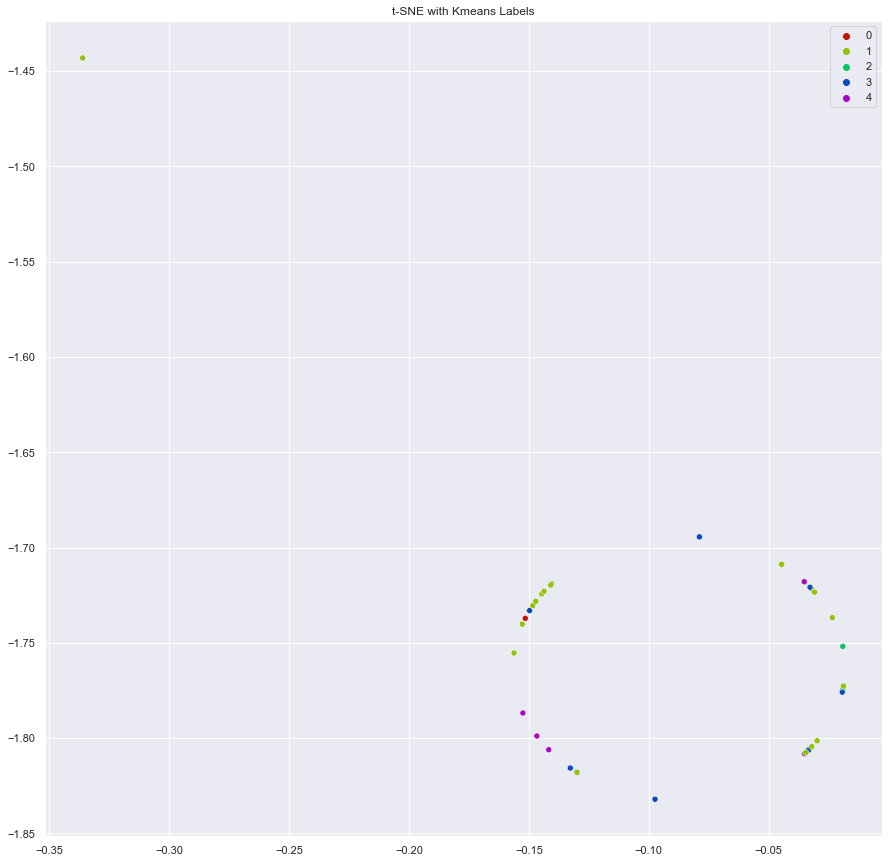

In [264]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(5, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

The labeled plot gives better insight into how the papers are grouped. It is interesting that both k-means and t-SNE are able to agree on certain clusters even though they were ran independetly. The location of each paper on the plot was determined by t-SNE while the label (color) was determined by k-means. If we look at a particular part of the plot where t-SNE has grouped many articles forming a cluster, it is likely that k-means is uniform in the labeling of this cluster (most of the cluster is the same color). This behavior shows that structure within the literature can be observed and measured to some extent. 

Now there are other cases where the colored labels (k-means) are spread out on the plot (t-SNE). This is a result of t-SNE and k-means finding different connections in the higher dimensional data. The topics of these papers often intersect so it hard to cleanly separate them. This effect can be observed in the formation of subclusters on the plot. These subclusters are a conglomeration of different k-means labels but may share some connection determined by t-SNE.

This organization of the data does not act as a simple search engine. The clustering + dimensionality reduction is performed on the mathematical similarities of the publications. As an unsupervised approach, the algorithms may even find connections that were unnaparent to humans. This may highlight hidden shared information and advance further research.


# NMF

In [337]:
import en_ner_bc5cdr_md
nlp = spacy.load("en_ner_bc5cdr_md")

In [338]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
nmf = NMF(n_components=20, random_state=1,
          alpha=.1, l1_ratio=.5).fit(X)

In [339]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(5, 4, figsize=(30, 60), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [340]:
#vectorizer = TfidfVectorizer(max_features= 2 ** 12)


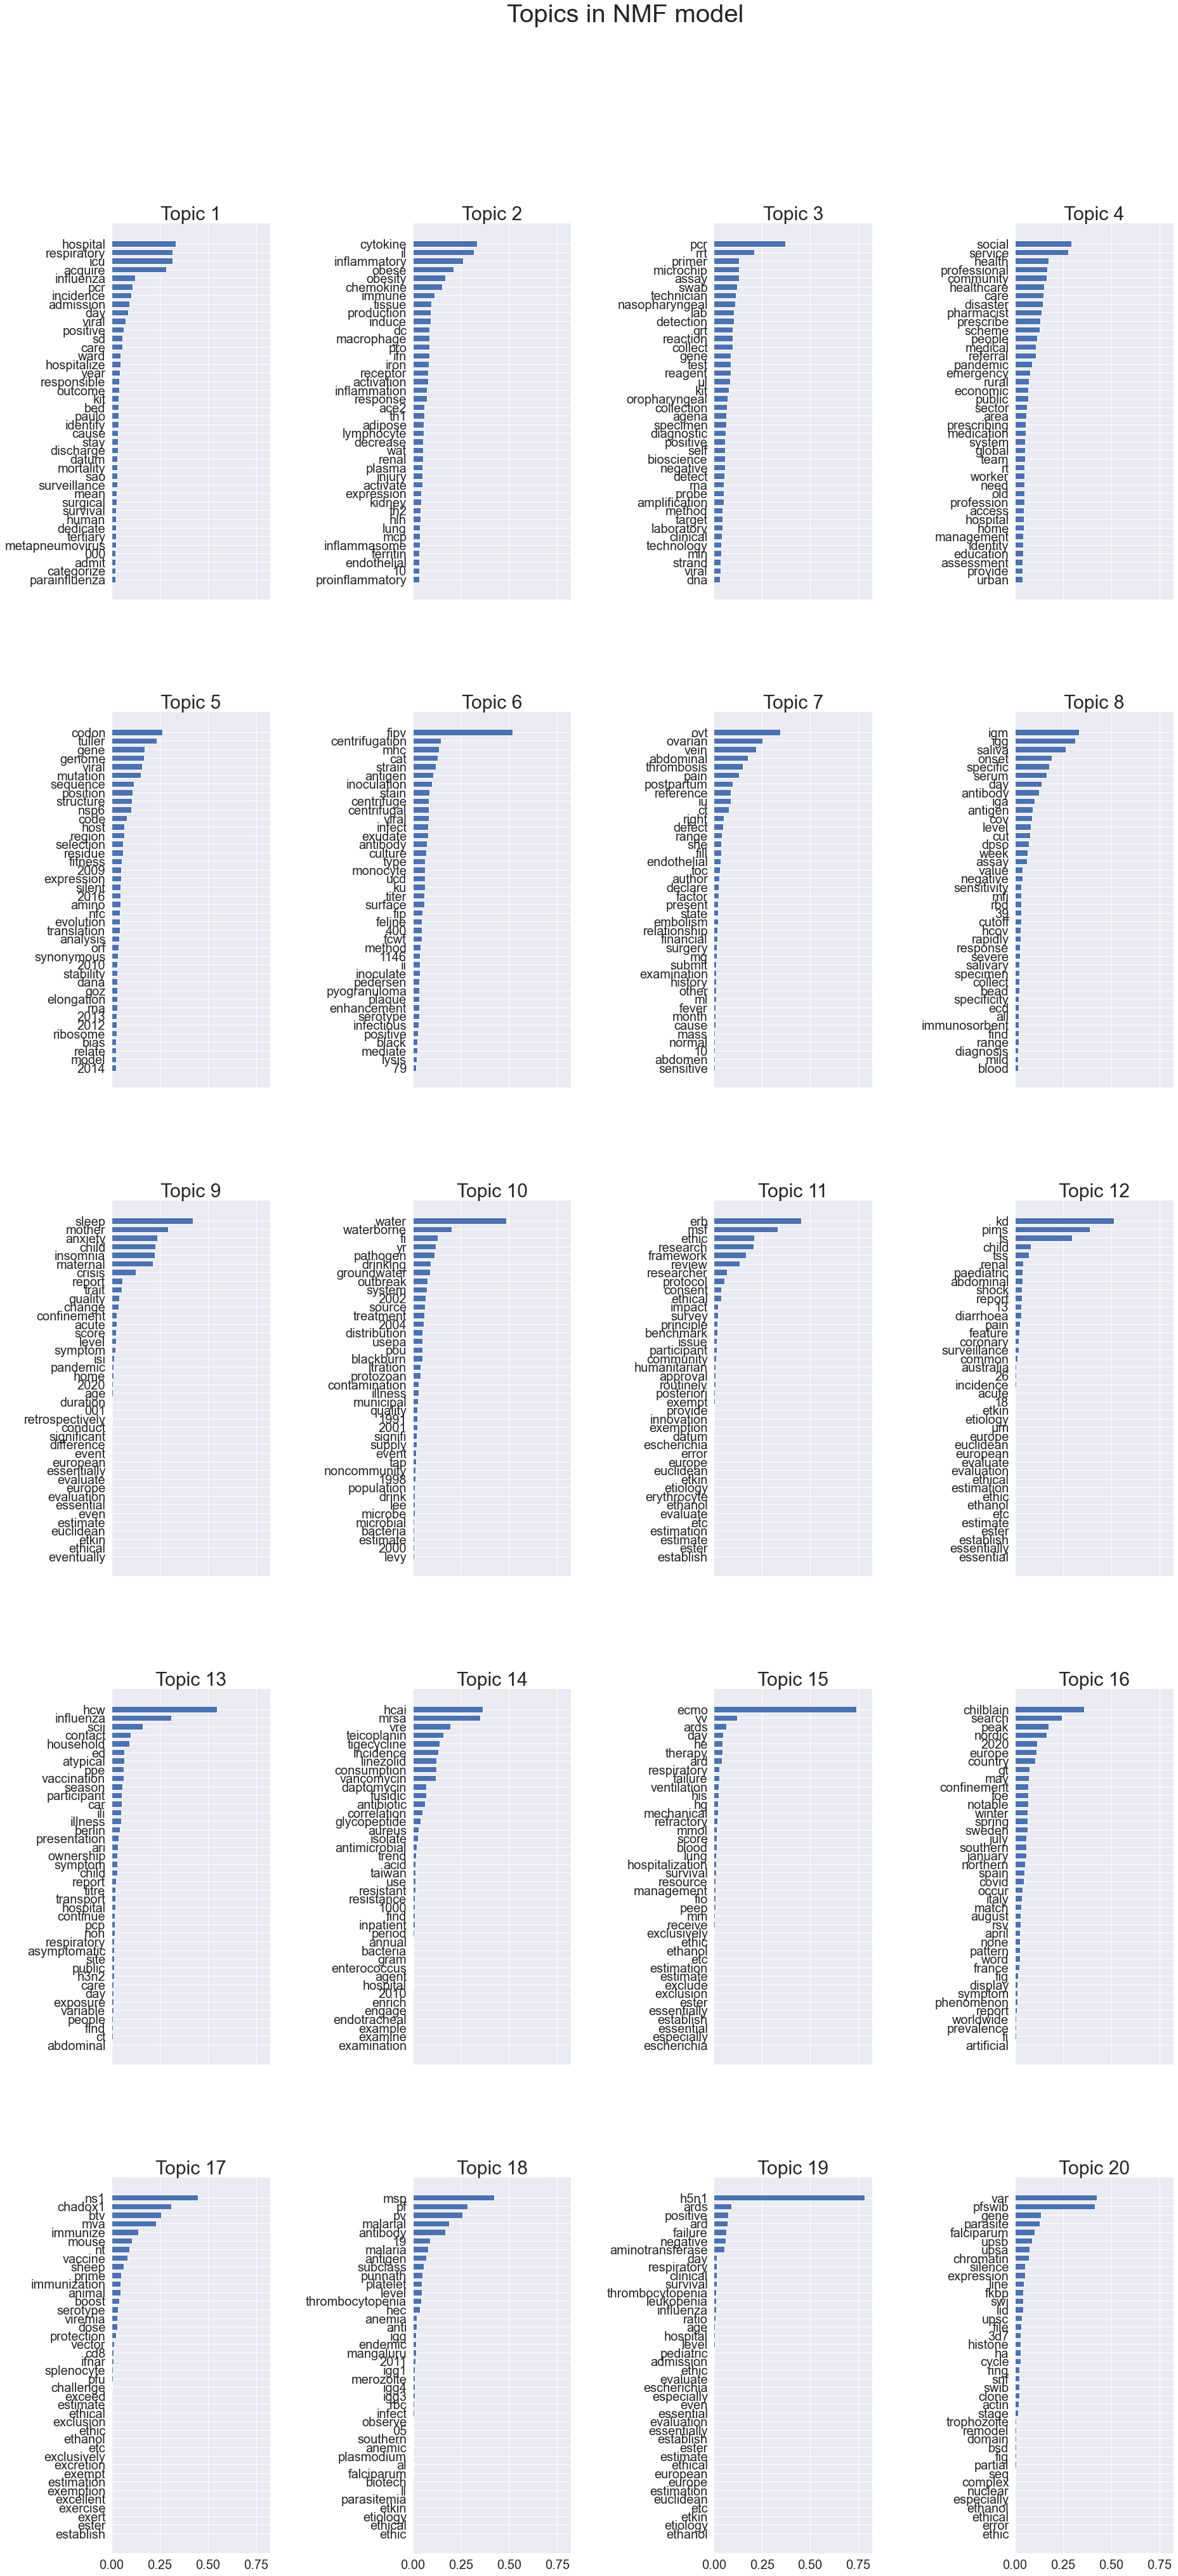

In [341]:
tfidf_feature_names = vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, 40,
               'Topics in NMF model')

In [342]:
all_keywords = []
for topic_idx, topic in enumerate(nmf.components_):
    #top words = 100
    top_features_ind = topic.argsort()[:-40 - 1:-1]
    top_features = [tfidf_feature_names[i] for i in top_features_ind]
    all_keywords.append(top_features)

In [343]:
for num_clus in range(0,20):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ','.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    TERM_LIST = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,TERM_LIST )
    print("")

*************Cluster  0 *********************
hospital,respiratory,icu,acquire,influenza,pcr,incidence,admission,day,viral,positive,sd,care,ward,hospitalize,year,responsible,outcome,kit,bed,paulo,identify,cause,stay,discharge,datum,mortality,sao,surveillance,mean,surgical,survival,human,dedicate,tertiary,metapneumovirus,000,admit,categorize,parainfluenza
-------------------------------------------
TERM_LIST :  ['parainfluenza']

*************Cluster  1 *********************
cytokine,il,inflammatory,obese,obesity,chemokine,immune,tissue,production,induce,dc,macrophage,pro,ifn,iron,receptor,activation,inflammation,response,ace2,th1,adipose,lymphocyte,decrease,wat,renal,plasma,injury,activate,expression,kidney,th2,hlh,lung,mcp,inflammasome,ferritin,endothelial,10,proinflammatory
-------------------------------------------
TERM_LIST :  ['obesity', 'inflammation']

*************Cluster  2 *********************
pcr,rrt,primer,microchip,assay,swab,technician,nasopharyngeal,lab,detection,qrt,r

# LDA

In [272]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

tf = CountVectorizer(max_df=0.9, min_df=5, stop_words='english')
tff = tf.fit_transform(text)
lda = LatentDirichletAllocation(n_components=20, max_iter=10, learning_method='online', random_state=42)
lda.fit(tff)


LatentDirichletAllocation(learning_method='online', n_components=20,
                          random_state=42)

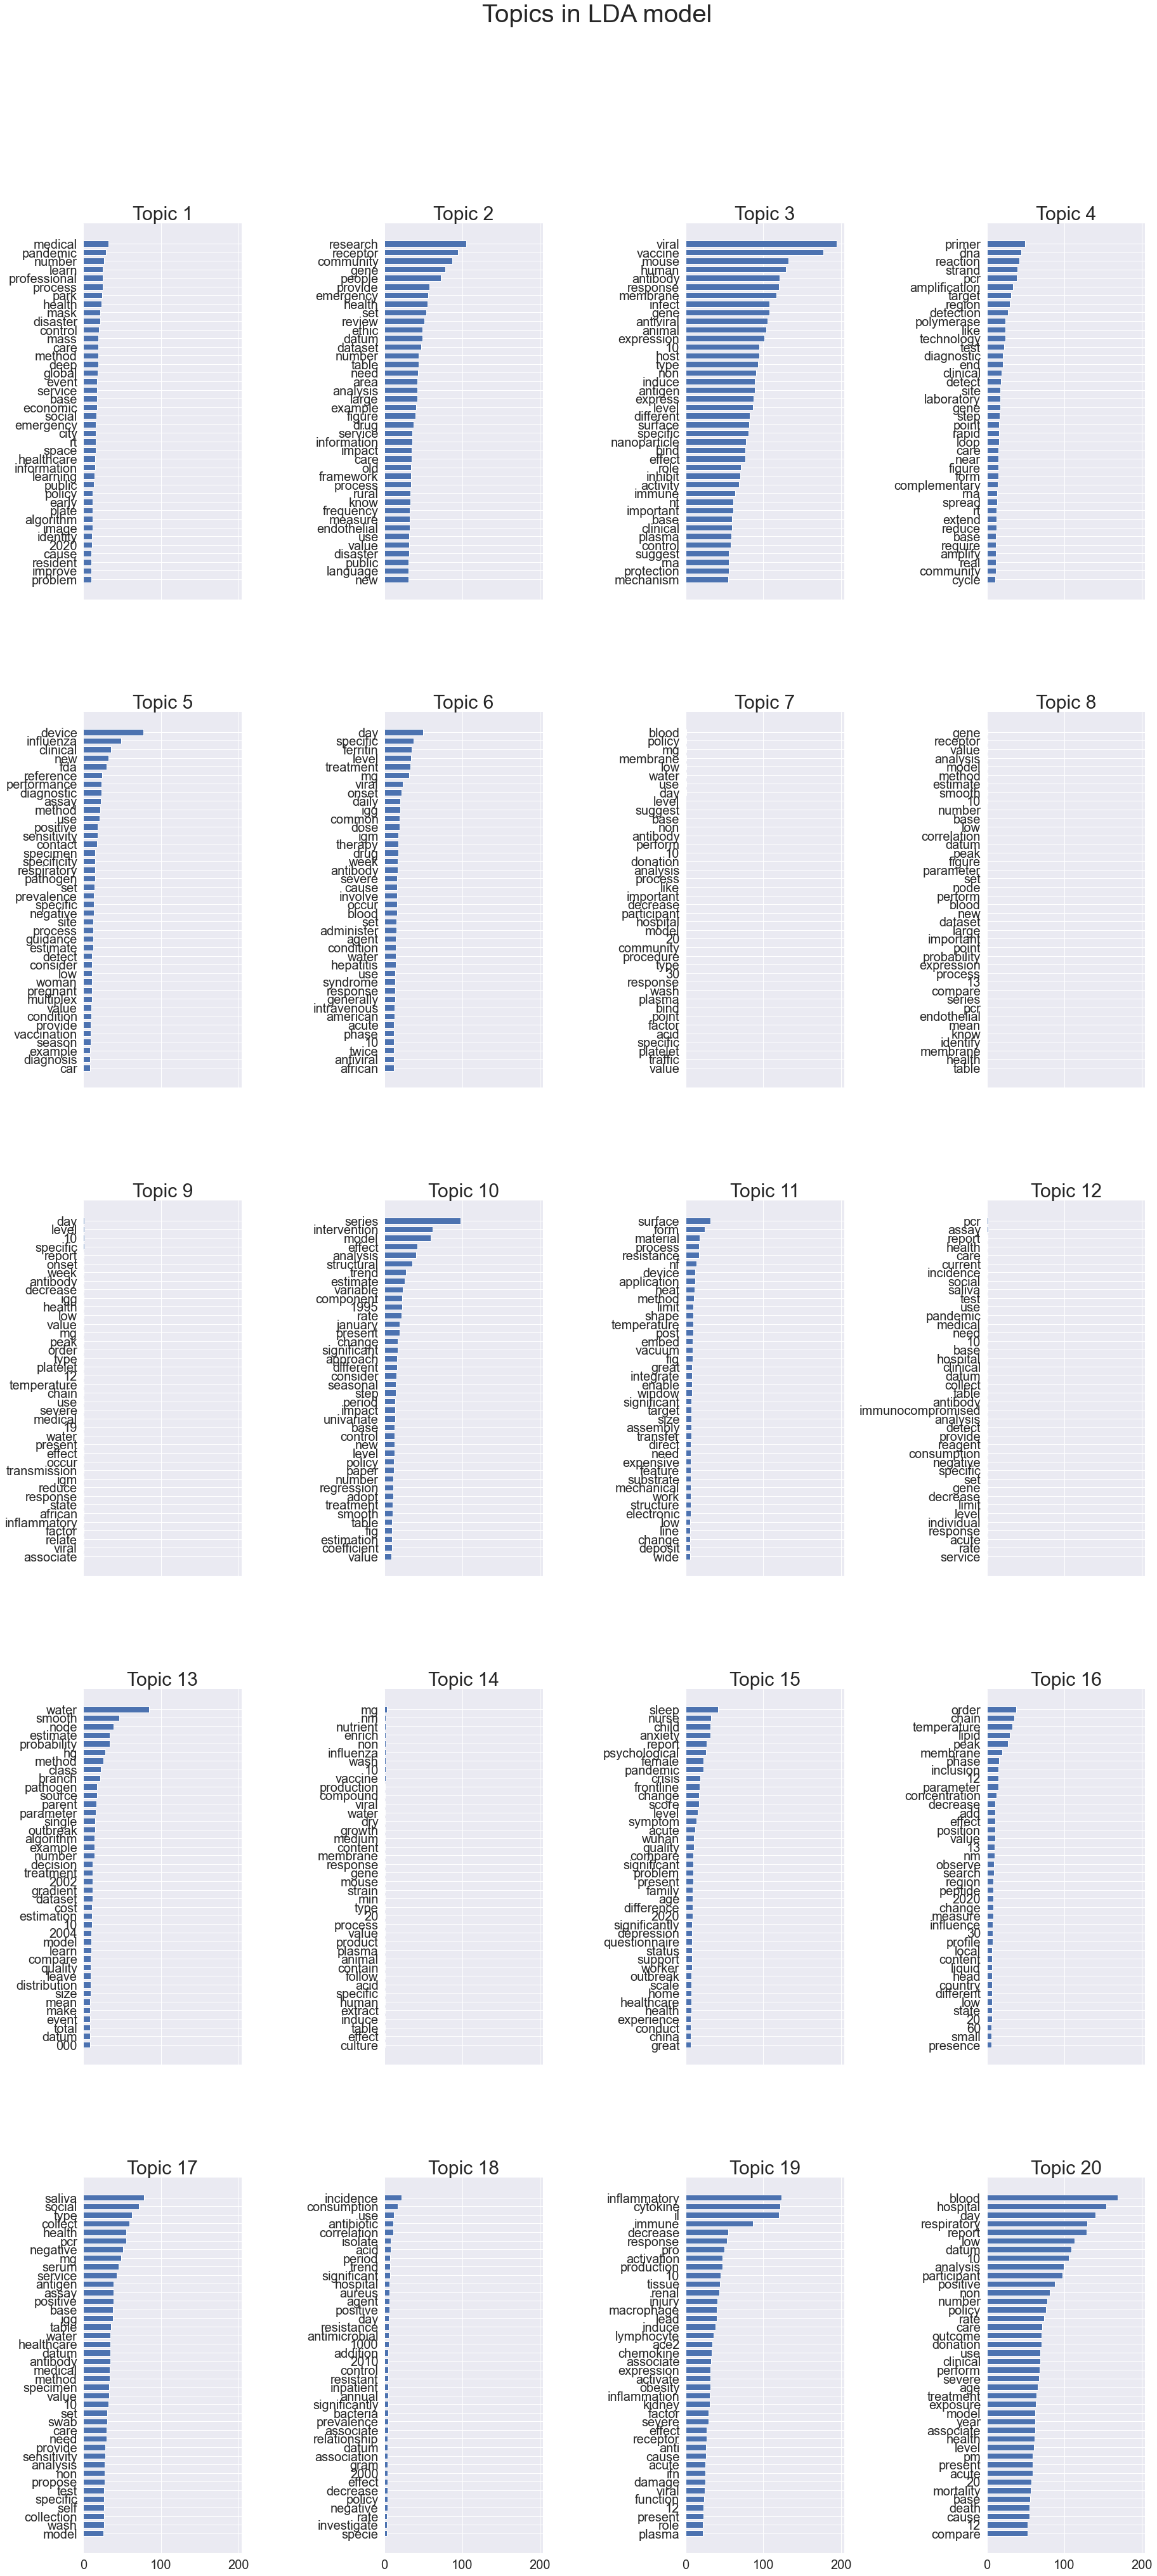

In [273]:
tf_feature_names = tf.get_feature_names()
plot_top_words(lda, tf_feature_names, 40, 'Topics in LDA model')

In [274]:
all_keywords = []
for topic_idx, topic in enumerate(nmf.components_):
    #top words = 100
    top_features_ind = topic.argsort()[:-100 - 1:-1]
    top_features = [tfidf_feature_names[i] for i in top_features_ind]
    all_keywords.append(top_features)

In [275]:
for num_clus in range(0,20):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ','.join(all_keywords[ ])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    TERM_LIST = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,TERM_LIST )
    print("")

*************Cluster  0 *********************
hospital,respiratory,icu,acquire,influenza,pcr,incidence,admission,day,viral,positive,sd,care,ward,hospitalize,year,responsible,outcome,kit,bed,paulo,identify,cause,stay,discharge,datum,mortality,sao,surveillance,mean,surgical,survival,human,dedicate,tertiary,metapneumovirus,000,admit,categorize,parainfluenza,rhinovirus,report,ventilation,of,syncytial,lmics,brazil,critical,we,number,our,30,adenovirus,28,median,failure,observational,mechanical,canadian,95,surge,interquartile,burden,2015,overall,proportion,interval,management,use,perform,suspect,variable,severe,that,coronavirus,country,enterovirus,evolution,ethical,endothelium,endotracheal,euclidean,etkin,etiology,endpoint,ethanol,exact,ethic,europe,etc,examination,encounter,estimation,estimate,exacerbation,european,encourage,evolve,endemic,evidence
-------------------------------------------
TERM_LIST :  ['parainfluenza', 'enterovirus']

*************Cluster  1 *********************
cytokine

kd,pims,ts,child,tss,renal,paediatric,abdominal,shock,report,13,diarrhoea,pain,feature,coronary,surveillance,common,australia,26,incidence,acute,18,etkin,etiology,μm,europe,euclidean,european,evaluate,evaluation,ethical,estimation,ethic,ethanol,etc,estimate,ester,establish,essentially,essential,especially,escherichia,erythrocyte,error,even,evolution,event,eventually,exist,exhibit,exert,exercise,exemption,exempt,excretion,exclusively,exclusion,exclude,exchange,excessive,excess,exception,excellent,exceed,example,examine,examination,exact,exacerbation,evolve,evolutionary,era,evident,evidence,everyday,erb,equation,er,endotracheal,enrol,enrichment,enrich,enhancement,enhance,engraftment,english,engineer,engagement,engage,enforcement,energy,endpoint,endothelium,equivalent,endothelial,endosome,endoplasmic,endonuclease,endolysosomal,endogenous
-------------------------------------------
TERM_LIST :  ['shock', 'pain']

*************Cluster  12 *********************
hcw,influenza,scii,contact,hou

var,pfswib,gene,parasite,falciparum,upsb,upsa,chromatin,silence,expression,line,fkbp,swi,lid,upsc,file,3d7,histone,ha,cycle,ring,snf,swib,clone,actin,stage,trophozoite,remodel,domain,bsd,fig,partial,seq,complex,nuclear,especially,ethanol,ethical,error,ethic,estimation,erythrocyte,etc,escherichia,enact,estimate,ester,establish,essentially,etkin,essential,etiology,evaluate,euclidean,exacerbation,exclude,exchange,excessive,excess,exception,excellent,exceed,example,examine,examination,exact,evolve,europe,evolutionary,evolution,evident,evidence,everyday,eventually,event,even,evaluation,era,european,erb,equine,er,energy,enter,ensure,enrol,enrichment,enrich,enhancement,enhance,engraftment,english,engineer,engagement,engage,enforcement,endpoint,equivalent,endotracheal,endothelium
-------------------------------------------
TERM_LIST :  ['falciparum']



# LSA

In [333]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

20

In [334]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0] ," ",end='')
    print(" ")

Topic 0: 
hospital  pcr  respiratory  care  day  viral  health   
Topic 1: 
cytokine  il  inflammatory  immune  obese  dc  receptor   
Topic 2: 
pcr  rrt  assay  primer  swab  detection  microchip   
Topic 3: 
gene  disaster  social  genome  fipv  codon  vaccine   
Topic 4: 
fipv  antibody  antigen  igg  igm  saliva  msp   
Topic 5: 
pcr  rrt  primer  il  cytokine  professional  assay   
Topic 6: 
ppe  pe  ovt  ed  hcw  abdominal  device   
Topic 7: 
fipv  aerosol  viral  intubation  infect  centrifugation  mhc   
Topic 8: 
sleep  aerosol  mother  saliva  maternal  intubation  anxiety   
Topic 9: 
intubation  device  procedure  water  aerosol  lisa  mg   
Topic 10: 
aerosol  vaccine  intubation  procedure  tracheal  surgical  lisa   
Topic 11: 
water  vaccine  sleep  mother  mg  child  maternal   
Topic 12: 
hcw  vaccine  device  influenza  dc  egypt  ns1   
Topic 13: 
lu  woman  pregnant  vaccine  youth  disaster  perception   
Topic 14: 
vaccine  woman  pregnant  ns1  lu  pregnancy  

In [335]:
all_keywords = []
for topic_idx, topic in enumerate(svd_model.components_):
    #top words = 100
    top_features_ind = topic.argsort()[:-40 - 1:-1]
    top_features = [tfidf_feature_names[i] for i in top_features_ind]
    all_keywords.append(top_features)


In [336]:
for num_clus in range(0,19):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ','.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    TERM_LIST = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,TERM_LIST )
    print("")

*************Cluster  0 *********************
hospital,pcr,respiratory,care,day,viral,health,report,cytokine,clinical,icu,service,positive,gene,pandemic,social,medical,inflammatory,influenza,community,response,il,datum,10,vaccine,2020,level,healthcare,people,system,we,analysis,device,specific,number,find,non,severe,immune,human
-------------------------------------------
TERM_LIST :  []

*************Cluster  1 *********************
cytokine,il,inflammatory,immune,obese,dc,receptor,ace2,expression,antigen,fipv,induce,viral,obesity,tissue,chemokine,iron,gene,production,antibody,ifn,macrophage,activation,renal,response,mhc,plasma,pro,monocyte,kidney,infect,mouse,antiviral,saliva,inflammation,vns,endothelial,activate,express,lymphocyte
-------------------------------------------
TERM_LIST :  []

*************Cluster  2 *********************
pcr,rrt,assay,primer,swab,detection,microchip,positive,saliva,reaction,nasopharyngeal,collect,technician,test,specimen,respiratory,kit,negative,gene,q

# Topic Modeling on Each Cluster

Now we will attempt to find the most significant words in each clusters. K-means clustered the articles but did not label the topics. Through topic modeling we will find out what the most important terms for each cluster are. This will add more meaning to the cluster by giving keywords to quickly identify the themes of the cluster.

For topic modeling, we will use LDA (Latent Dirichlet Allocation). In LDA, each document can be described by a distribution of topics and each topic can be described by a distribution of words[.](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158)

In [280]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

First we will create 20 vectorizers, one for each of our cluster labels

In [281]:
vectorizers = []
    
for ii in range(0, 5):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

Now we will vectorize the data from each of our clusters

In [282]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'text_lemmatized_url_html']))
        #d'ou vient df['y'] =   y_pred = kmeans.fit_predict(X_reduced)      df['y'] = y_pred       df['y']
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

Not enough instances in cluster: 0


In [283]:
len(vectorized_data)

5

Topic modeling will be performed through the use of Latent Dirichlet Allocation (LDA). This is a generative statistical model that allows sets of words to be explained by a shared topic

# Topic modeling on each cluster using LDA : 

In [284]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 6

lda_models = []
for ii in range(0, 5):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    

For each cluster, we had created a correspoding LDA model in the previous step. We will now fit_transform all the LDA models on their respective cluster vectors

In [285]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Extracts the keywords from each cluster

In [286]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=20):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

Append list of keywords for a single cluster to 2D list of length NUM_TOPICS_PER_CLUSTER

In [287]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [288]:
for i in range(0,5):
    print(all_keywords[i])

['viral', 'hospital', 'membrane', 'participant', 'series', 'antiviral', 'respiratory', 'host', 'gene', 'positive', 'policy', 'mouse', 'clinical', 'donation', 'antibody', 'acute', 'intervention', 'week', 'bind', 'inhibit', 'structure', 'vaccine', 'genome', 'activity', 'type', 'plasma', 'surface', 'expression', 'animal', 'non', 'human', 'effect', 'mechanism', 'order', 'structural', 'control', 'protection', 'incidence', 'drug', 'agent', 'specific', 'probability', 'dose', 'learn', 'chain', 'line', 'temperature', 'parasite', 'number', 'use', 'parameter', 'vector', 'trend', 'lipid', 'level', 'analysis', 'challenge', 'process', 'day', 'estimate', 'treatment', 'response', 'fig', 'demonstrate', 'peak', 'daily', 'low', 'acid', 'water', 'cause', 'propose', 'influenza', 'datum', 'blood', 'method', 'class', 'base', 'interval', 'normal', 'rate', 'sequence', 'work', 'algorithm', 'set', 'identify', 'model', 'woman', 'potential', 'report']
['macrophage', 'lymphocyte', 'treatment', 'acute', 'severe', 'm

IndexError: list index out of range

In [ ]:
for num_clus in range(0,5):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ','.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    TERM_LIST = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,TERM_LIST )
    print("")

# Topic modeling on each cluster using NMF : 

In [ ]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 6

nmf_models = []
for ii in range(0, 5):
    # nmf
    nmf = NMF(n_components=NUM_TOPICS_PER_CLUSTER, random_state=1,alpha=.1, l1_ratio=.5)
    nmf_models.append(nmf)
    
nmf_models[0]

In [ ]:
clusters_nmf_data = []

for current_cluster, nmf in enumerate(nmf_models):
    print("Current Cluster: " + str(current_cluster))
    if vectorized_data[current_cluster] != None:
        clusters_nmf_data.append((nmf.fit_transform(vectorized_data[current_cluster])))

In [ ]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=20):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [ ]:
all_keywords = []
for current_vectorizer, nmf in enumerate(nmf_models):
    # print("Current Cluster: " + str(current_vectorizer))
    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(nmf, vectorizers[current_vectorizer]))

In [ ]:
for i in range(0,5):
    print(all_keywords[i])

## travail realisé :
 - detection automatique des noms de maladies
 - construction d'un corpus en utilisant les noms des maladies detectés

In [ ]:
for num_clus in range(0,5):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ','.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    TERM_LIST = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,TERM_LIST )
    print("")


# Word's Similarity

In [347]:
import spacy
nlp = spacy.load('en_core_web_md')
cov_word =nlp("coronavirus")
for num_clus in range(0,20):
    print("*************Cluster ",num_clus,"*********************")
    str1 = ' '.join(all_keywords[num_clus])
    doc = nlp(str1)
    print(str1)
    print("-------------------------------------------")
    words = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    print("TERM_LIST : " ,words)
    print("")
    for token in doc:
        #print(token.text, token.has_vector, token.vector_norm, token.is_oov) 
        if cov_word.similarity(token) > 0.5 :
            print("Similarity Between {",cov_word,"} and {",token,"} is :   ",cov_word.similarity(token))
    print("__________________________________________________________________")


*************Cluster  0 *********************
hospital respiratory icu acquire influenza pcr incidence admission day viral positive sd care ward hospitalize year responsible outcome kit bed paulo identify cause stay discharge datum mortality sao surveillance mean surgical survival human dedicate tertiary metapneumovirus 000 admit categorize parainfluenza
-------------------------------------------
TERM_LIST :  []

Similarity Between { coronavirus } and { influenza } is :    0.6127955278394492
Similarity Between { coronavirus } and { viral } is :    0.6789279758381194
__________________________________________________________________
*************Cluster  1 *********************
cytokine il inflammatory obese obesity chemokine immune tissue production induce dc macrophage pro ifn iron receptor activation inflammation response ace2 th1 adipose lymphocyte decrease wat renal plasma injury activate expression kidney th2 hlh lung mcp inflammasome ferritin endothelial 10 proinflammatory
-----

<ipython-input-347-a9ecc4291df1>:15: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  if cov_word.similarity(token) > 0.5 :



-------------------------------------------
TERM_LIST :  []

Similarity Between { coronavirus } and { escherichia } is :    0.5350284756573006
__________________________________________________________________
*************Cluster  11 *********************
kd pims ts child tss renal paediatric abdominal shock report 13 diarrhoea pain feature coronary surveillance common australia 26 incidence acute 18 etkin etiology μm europe euclidean european evaluate evaluation ethical estimation ethic ethanol etc estimate ester establish essentially essential
-------------------------------------------
TERM_LIST :  []

__________________________________________________________________
*************Cluster  12 *********************
hcw influenza scii contact household ed atypical ppe vaccination season participant car ili illness berlin presentation ari ownership symptom child report titre transport hospital continue pcp non respiratory asymptomatic site public h3n2 care day exposure variable peopl

In [420]:
import spacy
nlp = spacy.load('en_core_web_md')
cov_word =nlp("coronavirus")
top_similar = []
for num_clus in range(0,20):
    str1 = ' '.join(all_keywords[num_clus])
    doc = nlp(str1)
    words = [e.text for e in doc.ents if (e.label_ == "DISEASE")]
    for token in doc:
        if cov_word.similarity(token) > 0.5 :
            top_similar.append([token.text , cov_word.similarity(token)])
LL = sorted(top_similar, key=lambda tup: tup[1])
LL1 = LL
for a in LL :
    if a[0]  in LL1:
        LL1.append(a)
LL1

<ipython-input-420-3f16a83d8ac5>:10: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  if cov_word.similarity(token) > 0.5 :


[['pandemic', 0.5010447134454742],
 ['pandemic', 0.5010447134454742],
 ['microbe', 0.5071558643122325],
 ['bacteria', 0.5071558643122325],
 ['bacteria', 0.5071558643122325],
 ['inoculation', 0.516190829505902],
 ['vaccination', 0.516190829505902],
 ['immunization', 0.516190829505902],
 ['immune', 0.524877441820188],
 ['lymphocyte', 0.524877441820188],
 ['infectious', 0.5332051459892988],
 ['malaria', 0.5332051459892988],
 ['lysis', 0.5350284756573006],
 ['waterborne', 0.5350284756573006],
 ['pathogen', 0.5350284756573006],
 ['microbial', 0.5350284756573006],
 ['escherichia', 0.5350284756573006],
 ['aureus', 0.5350284756573006],
 ['antimicrobial', 0.5350284756573006],
 ['escherichia', 0.5350284756573006],
 ['escherichia', 0.5350284756573006],
 ['protozoan', 0.5745848854645642],
 ['malarial', 0.5745848854645642],
 ['plasmodium', 0.5745848854645642],
 ['falciparum', 0.5745848854645642],
 ['parasite', 0.5745848854645642],
 ['falciparum', 0.5745848854645642],
 ['outbreak', 0.574623878493011

In [ ]:
from Bio import Entrez
from Bio import Medline
import json


MAX_COUNT = 3
for TERM in TERM_LIST:
    Entrez.email = 'A.N.Other@example.com'
    h = Entrez.esearch(db='pubmed', retmax=MAX_COUNT, term=TERM)
    result = Entrez.read(h)
    ids = result['IdList']
    h = Entrez.efetch(db='pubmed', id=ids, rettype='medline', retmode='json')
    records = Medline.parse(h)
    i=0
    for record in records:
        filename="fichier_"+TERM+str(i)+".json"
        json.dump(record, open(".\\new_corpus\\"+filename, 'w'))
        data = json.load(open(".\\new_corpus\\"+filename))
        i=i+1
[(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents]

In [ ]:
len(all_keywords)